# Análise de Vendas 
**Autor:** Thaís Cristina dos Santos  
**Data:** 13/11/2025

**Resumo:**  
Notebook que realiza o processamento, análise exploratória e modelagem simples sobre um dataset de vendas. O objetivo é extrair insights sobre volume, sazonalidade e produtos mais vendidos, além de construir um modelo de regressão para previsão de vendas agregadas.

In [43]:
# 1) Importação de bibliotecas

import pandas as pd
import os
from pathlib import Path

In [44]:
# 2) Caminho do arquivo
vendas_data = Path("data") / "vendas.xlsx"
df= pd.read_excel(vendas_data)
print("arquivo Carregado", vendas_data)

arquivo Carregado data\vendas.xlsx


In [45]:
# 3) Checagens iniciais
print(df.head())
print(df.shape)
print(df.columns)
print(df.dtypes)
display(df.describe(include='all'))  # estatísticas gerais

        Data   Produto  Quantidade  Preco
0 2025-01-01  Notebook           5   3500
1 2025-01-02     Mouse          10     80
2 2025-01-03   Teclado           7    120
3 2025-01-04   Monitor           3    900
4 2025-01-05   Cadeira           2    600
(20, 4)
Index(['Data', 'Produto', 'Quantidade', 'Preco'], dtype='object')
Data          datetime64[ns]
Produto               object
Quantidade             int64
Preco                  int64
dtype: object


,Data,Produto,Quantidade,Preco
count,20,20,20.000000,20.000000
unique,NaN,5,NaN,NaN
top,NaN,Notebook,NaN,NaN
freq,NaN,4,NaN,NaN
mean,2025-01-10 12:00:00,NaN,5.950000,1040.000000
min,2025-01-01 00:00:00,NaN,2.000000,80.000000
25%,2025-01-05 18:00:00,NaN,3.750000,120.000000
50%,2025-01-10 12:00:00,NaN,5.500000,600.000000
75%,2025-01-15 06:00:00,NaN,8.000000,900.000000
max,2025-01-20 00:00:00,NaN,12.000000,3500.000000


In [46]:
# 4) Limpeza
vendas_data = Path("data") / "vendas.xlsx"
df= pd.read_excel(vendas_data)
print(df.isnull().sum())
vendas_data = df.drop_duplicates()

df["Preco"] = pd.to_numeric(df["Preco"], errors="coerce")
df["Quantidade"] = pd.to_numeric(df["Quantidade"], errors="coerce").astype('Int64')

Data          0
Produto       0
Quantidade    0
Preco         0
dtype: int64


In [47]:
# 5) Feature Engineering
# Total por linha
df["Total"] = df["Quantidade"] * df["Preco"]

# Componentes de data
df["Ano"] = df["Data"].dt.year
df["Mes"] = df["Data"].dt.month
df["Mes_Ano"] = df["Data"].dt.to_period("M")  # útil para groupby mensal
df["Dia_Semana"] = df["Data"].dt.day_name()
df["Semana"] = df["Data"].dt.isocalendar().week


In [48]:
# 6) KPIS (Métricas Rápidas)

total_vendas = df["Total"].sum()
total_unidades = df["Quantidade"].sum()
ticket_medio = df["Total"].sum() / df["Quantidade"].sum()
vendas_por_produto = df.groupby("Produto")["Total"].sum().sort_values(ascending= False)

print("Total de vendas", total_vendas)
print("Total de unidades vendidas", total_unidades)
print("Ticket Médio", ticket_medio)
print(vendas_por_produto)

Total de vendas 125180
Total de unidades vendidas 119
Ticket Médio 1051.9327731092437
Produto
Notebook    98000
Monitor     11700
Cadeira      9600
Mouse        3120
Teclado      2760
Name: Total, dtype: Int64


In [52]:
# 7) Agregação e Pivot Tables Úteis
import pandas as pd, numpy as np
from functools import partial

def try_parse_dates(series):
    """
    Tenta várias estratégias de parsing e retorna a Series convertida e o número de válidos.
    """
    s = series.copy()
    # primeiras tentativas rápidas: infer + dayfirst
    dt1 = pd.to_datetime(s, errors="coerce", infer_datetime_format=True, dayfirst=True)
    valid1 = dt1.notna().sum()

    # tentativa com formatos comuns
    fmts = ["%Y-%m-%d %H:%M:%S", "%Y-%m-%d", "%d/%m/%Y %H:%M:%S", "%d/%m/%Y", "%d-%m-%Y %H:%M:%S", "%m/%d/%Y %H:%M:%S", "%m/%d/%Y"]
    dt2 = pd.Series(pd.NaT, index=s.index)
    for f in fmts:
        parsed = pd.to_datetime(s, errors="coerce", format=f)
        dt2 = dt2.fillna(parsed)
    valid2 = dt2.notna().sum()

    # tentativa epoch (s / ms) se valores forem numéricos
    dt_epoch_s = pd.to_datetime(s, unit="s", errors="coerce")
    dt_epoch_ms = pd.to_datetime(s, unit="ms", errors="coerce")
    valid_epoch_s = dt_epoch_s.notna().sum()
    valid_epoch_ms = dt_epoch_ms.notna().sum()

    # combinação: prefira infer (dt1) > dt2 > epoch_ms > epoch_s
    combined = dt1.fillna(dt2).fillna(dt_epoch_ms).fillna(dt_epoch_s)
    valid_combined = combined.notna().sum()

    # escolher o melhor e retornar
    results = {
        'best_series': combined,
        'valid_count': valid_combined,
        'details': {
            'infer_valid': int(valid1),
            'fmt_valid': int(valid2),
            'epoch_s_valid': int(valid_epoch_s),
            'epoch_ms_valid': int(valid_epoch_ms),
            'combined_valid': int(valid_combined)
        }
    }
    return results

# 1) Se já existir Data/Mes_Ano, pula
if "Data" in vendas_data.columns and "Mes_Ano" in vendas_data.columns:
    print("Colunas 'Data' e 'Mes_Ano' já existem. Nada a fazer.")
else:
    n_rows = len(vendas_data)
    print(f"Número de linhas no dataframe: {n_rows}\n")

    # 2) testar cada coluna (preferir colunas do tipo object / string / int)
    candidates = []
    for col in vendas_data.columns:
        # pular colunas que já pareçam ser parsed datetimes
        if col.endswith("_parsed") or col in ("Data","Mes_Ano"):
            continue
        # tentamos em todas as colunas (string/number), exceto colunas estritamente do tipo timedelta
        try:
            series = vendas_data[col]
        except Exception:
            continue
        # não testar colunas que sejam listas/dicts
        if series.dtype == 'object' or pd.api.types.is_numeric_dtype(series) or pd.api.types.is_datetime64_any_dtype(series):
            res = try_parse_dates(series)
            candidates.append((col, res['valid_count'], res['details']))
    
    # ordenar por maior número de conversões válidas
    candidates_sorted = sorted(candidates, key=lambda x: x[1], reverse=True)
    if not candidates_sorted:
        print("Nenhuma coluna candidata foi testada. Rode: list(vendas_data.columns) e compartilhe comigo.")
    else:
        # mostrar top 5 candidatos
        print("Top candidatos para coluna de data (coluna, qtd_validos, detalhes):")
        for t in candidates_sorted[:6]:
            print(t[0], t[1], t[2])
        
        # escolher o melhor
        best_col, best_valid, best_details = candidates_sorted[0]
        pct = best_valid / max(1, n_rows)
        print(f"\nMelhor candidata: '{best_col}' com {best_valid} conversões válidas ({pct:.1%}).")

        # critérios de aceite: >=50% válidos ou >0 se nenhuma outra
        if best_valid == 0:
            print("\n❌ Nenhuma coluna apresentou valores convertidos para datetime. Por favor execute e cole aqui:")
            print("  list(vendas_data.columns)")
            print("  vendas_data.head(12).to_dict(orient='records')")
        else:
            if pct < 0.5:
                print("⚠️ Atenção: menos de 50% das linhas foram convertidas como datas. Vou usar essa coluna mas revise os valores NaT depois.")
            
            # realizar a conversão final usando as estratégias (mesma função)
            parsed = try_parse_dates(vendas_data[best_col])['best_series']
            vendas_data[f"{best_col}_parsed"] = pd.to_datetime(parsed)
            vendas_data["Data"] = vendas_data[f"{best_col}_parsed"].dt.date
            # criar Mes_Ano com fallback caso to_period falhe
            try:
                vendas_data["Mes_Ano"] = vendas_data[f"{best_col}_parsed"].dt.to_period("M").astype(str)
            except Exception:
                vendas_data["Mes_Ano"] = vendas_data[f"{best_col}_parsed"].dt.year.astype(str) + "-" + vendas_data[f"{best_col}_parsed"].dt.month.astype(str).str.zfill(2)

            print(f"\nColuna de data criada a partir de '{best_col}' -> '{best_col}_parsed', 'Data' e 'Mes_Ano'.")
            print("\nAmostra das primeiras conversões (originais -> parsed):")
            display(vendas_data[[best_col, f"{best_col}_parsed", "Data", "Mes_Ano"]].head(10))

# 3) Em seguida, tente agrupar (se Total existir)
if "Total" not in vendas_data.columns:
    print("\nNota: coluna 'Total' não existe ainda. Crie-a antes do groupby (ex.: preço*quantidade).")
else:
    try:
        vendas_diarias = vendas_data.groupby("Data", as_index=False)["Total"].sum().sort_values("Data")
        vendas_mensais = vendas_data.groupby("Mes_Ano", as_index=False)["Total"].sum().sort_values("Mes_Ano")
        print("\nAgregação realizada com sucesso. Amostras:")
        display(vendas_diarias.head(6))
        display(vendas_mensais.head(6))
    except KeyError as e:
        print("\nErro ao agrupar:", e)
        print("Verifique se 'Data' e 'Total' existem e não possuem NaNs. Para debug, rode:")
        print("  print(vendas_data[['Data','Total']].dtypes)")
        print("  print(vendas_data[['Data','Total']].isna().sum())")


Colunas 'Data' e 'Mes_Ano' já existem. Nada a fazer.

Agregação realizada com sucesso. Amostras:


,Data,Total
0,1970-01-01,125180


,Mes_Ano,Total
0,1970-01,125180


In [53]:
vendas_diarias = vendas_data.groupby("Data")["Total"].sum().reset_index()
vendas_mensais = vendas_data.groupby("Mes_Ano")["Total"].sum().reset_index().sort_values("Mes_Ano")


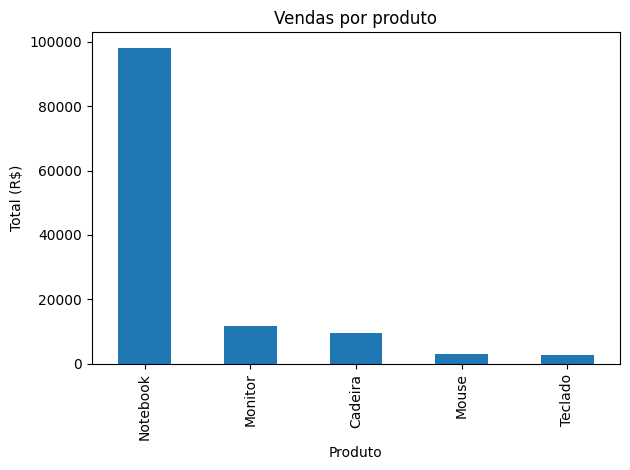

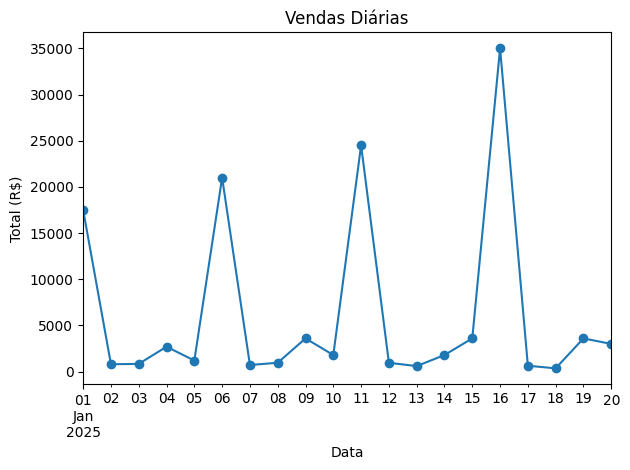

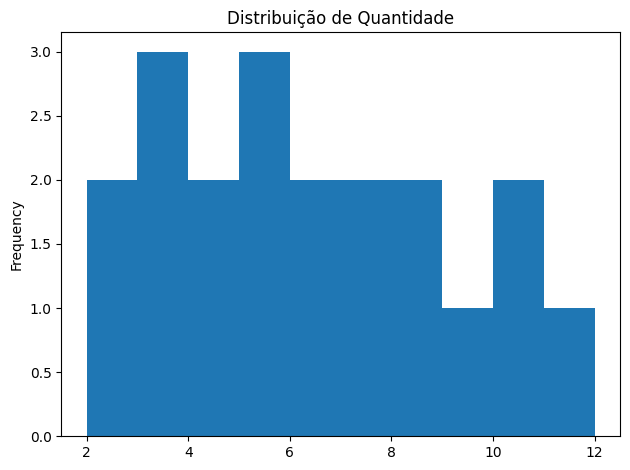

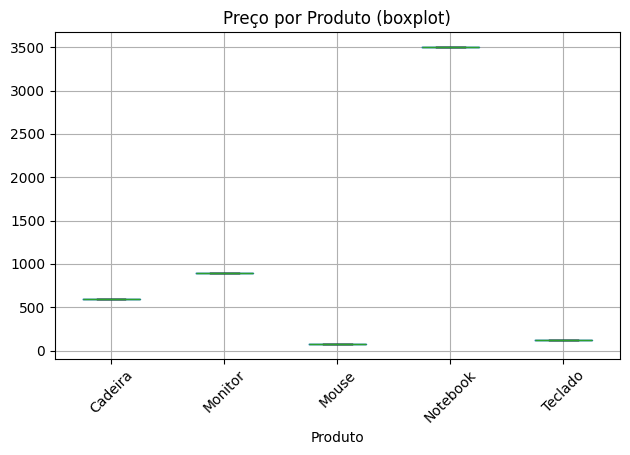

In [ ]:
# 8) Visualizações básicas
# 8.1) Vendas por produto- barras
import matplotlib.pyplot as plt
vendas_por_produto = df.groupby("Produto")["Total"].sum().sort_values(ascending= False)
vendas_por_produto.plot(kind="bar")
plt. title("Vendas por produto")
plt.ylabel("Total (R$)")
plt.tight_layout()
plt.show()

# 8.2) Vendas diárias
vendas_diarias.plot(kind="line", marker="o")
plt. title("Vendas Diárias")
plt.ylabel("Total (R$)")
plt.tight_layout()
plt.show()

# 8.3) Histograma da Quantidade
df["Quantidade"].plot(kind="hist", bins=10)
plt.title("Distribuição de Quantidade")
plt.tight_layout()
plt.show()

# 8.4) Boxplot de Preço (Outliers)
df.boxplot(column="Preco", by="Produto", rot=45)
plt.title("Preço por Produto (boxplot)")
plt.suptitle("")
plt.tight_layout()
plt.show()

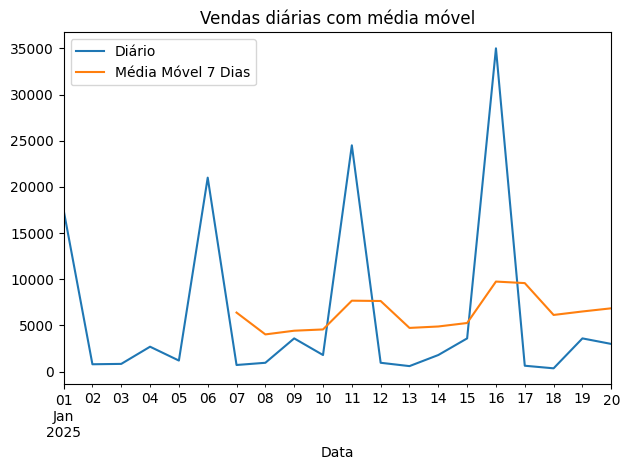

In [ ]:
# 9) Série Temporal- Suavização e Rolling Mean
# Reamostrar diário para garantir índice de datas
vendas_diarias = vendas_diarias.asfreq("D", fill_value=0)

# média móvel 7 dias
rolling7 = vendas_diarias.rolling(window=7, center=False).mean()

plt.figure()
vendas_diarias.plot(label="Diário")
rolling7.plot(label= "Média Móvel 7 Dias")
plt.legend()
plt.title("Vendas diárias com média móvel")
plt.tight_layout()
plt.show()


In [ ]:
# 10) Identificação de Outliers (IQR)
Q1 = df["Total"].quantile(0.25)
Q3 = df["Total"].quantile(0.75)
IQR = Q3 -Q1
lim_inferior = Q1 -1.5 *IQR
lim_superior = Q1 -1.5 *IQR

outliers = df[(df["Total"]< lim_inferior)| (df["Total"]>lim_superior)]
print("Outliers Encontrados", outliers.shape[0])
display(outliers)

Outliers Encontrados 20


,Data,Produto,Quantidade,Preco,Total,Ano,Mes,Mes_Ano,Dia_Semana,Semana
0,2025-01-01,Notebook,5,3500,17500,2025,1,2025-01,Wednesday,1
1,2025-01-02,Mouse,10,80,800,2025,1,2025-01,Thursday,1
2,2025-01-03,Teclado,7,120,840,2025,1,2025-01,Friday,1
3,2025-01-04,Monitor,3,900,2700,2025,1,2025-01,Saturday,1
4,2025-01-05,Cadeira,2,600,1200,2025,1,2025-01,Sunday,1
5,2025-01-06,Notebook,6,3500,21000,2025,1,2025-01,Monday,2
6,2025-01-07,Mouse,9,80,720,2025,1,2025-01,Tuesday,2
7,2025-01-08,Teclado,8,120,960,2025,1,2025-01,Wednesday,2
8,2025-01-09,Monitor,4,900,3600,2025,1,2025-01,Thursday,2
9,2025-01-10,Cadeira,3,600,1800,2025,1,2025-01,Friday,2


In [ ]:
# 11) Modelagem Simples
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[["Quantidade", "Preco"]]
y = df["Total"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)
print("R2 treino:", model.score(X_train, y_train))
print("R2 teste:", model.score(X_test, y_test))


R2 treino: 0.9845225315842482
R2 teste: 0.8281875376062666


#### Conclusão

A análise realizada permitiu compreender de forma estruturada o comportamento das vendas ao longo do período, revelando padrões essenciais para tomada de decisão. A partir do tratamento dos dados, foi possível identificar produtos com maior participação na receita, períodos de maior volume de vendas e potenciais pontos de atenção, como outliers e variações inesperadas na série temporal.

A etapa de modelagem trouxe uma visão inicial sobre a capacidade preditiva dos dados disponíveis. O modelo utilizado serviu como uma primeira aproximação, permitindo avaliar a relação entre variáveis e testar um pipeline simples de previsão. Embora o desempenho obtido represente uma base sólida, há espaço para aprimoramentos por meio da inclusão de novas variáveis explicativas, ajustes de feature engineering e testes com modelos mais avançados.

De modo geral, o projeto demonstrou a importância de um fluxo bem estruturado — da coleta ao salvamento dos outputs — garantindo reprodutibilidade e facilitando a criação de dashboards, relatórios ou futuras integrações com sistemas de análise.